In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys, os, glob, copy, re, shutil

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.convolution import Box1DKernel, convolve
from astroquery.sdss import SDSS
from astropy.wcs import WCS

from astropy.io import fits

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

## Get the data

We find all the object having an SDSS spectra (rouly) in the COSMOS field and z>0.3 (a 1-deg circle) using SQL query. We use SDSS because it has a decent data query tool.

In [2]:
from astroquery.sdss import SDSS

HSC_center = SkyCoord('10h00m28.60s +02d12m21.00s')

# NOTE: Columns other than ra, dec, and z are used for querying and downloading.
sql_query = f"""
SELECT 
  p.ra, p.dec, p.z, p.bestObjID, p.run2d, p.plate, p.fiberID, p.mjd
  from specObj p, dbo.fGetNearbyObjEq({HSC_center.ra.deg}, {HSC_center.dec.deg}, 60) n
  where   
    class = 'galaxy'  
    and z > 0.3   
    and zWarning = 0
    and n.objID = p.bestObjID
"""

query_result = SDSS.query_sql(sql_query)

query_result

ra,dec,z,bestObjID,run2d,plate,fiberID,mjd
float64,float64,float64,int64,str7,int64,int64,int64
150.17996,1.7688727,0.3458504,1237651753460433127,26,500,111,51994
149.63143,2.8682156,0.3530887,1237654599952564410,26,500,454,51994
150.41312,2.4098845,0.3845265,1237653665259061839,26,500,583,51994
150.44728,2.0539197,0.3231864,1237653664722190669,26,500,639,51994
150.04695,2.8619519,0.305437,1237654599952761094,26,501,326,52235
149.88264,2.4483435,0.3590711,1237653665258799410,26,501,344,52235
150.90537,2.5967453,0.4719288,1237651754534502823,26,501,482,52235
149.59686,1.3683156,0.5076139,1237651752923300204,v5_13_2,3828,872,55539
150.83233,1.9228992,0.5139835,1237653664722322100,v5_13_2,4737,21,55630


Plot them in the skymap

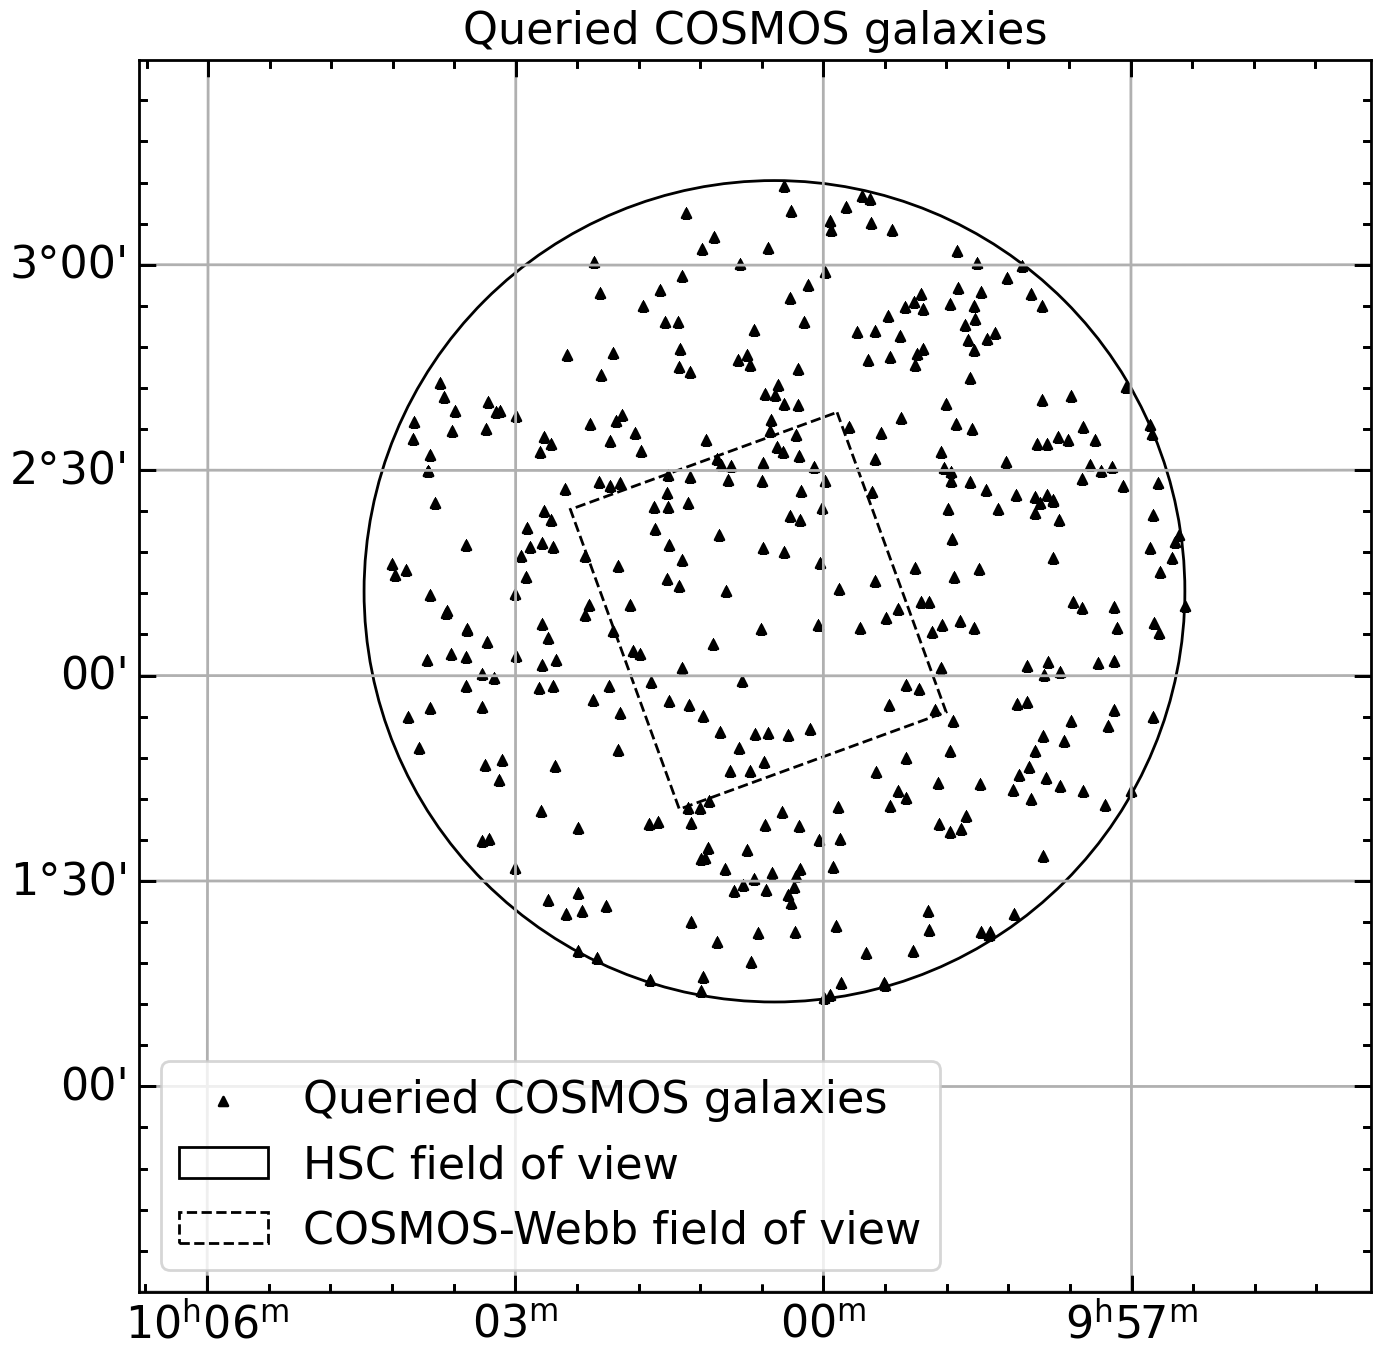

In [3]:
# Figure WCS
center_coord = SkyCoord("150d10m 2d0m")
width = 1.5*u.deg
wcs = WCS(naxis=2)
wcs.wcs.crpix = [1, 1]
wcs.wcs.cdelt = [-width.to_value(u.deg), width.to_value(u.deg)]
wcs.wcs.crval = [center_coord.ra.deg, center_coord.dec.deg]
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

fig = plt.figure(figsize=[8, 8], dpi=100)
ax1 = plt.axes(projection=wcs)
ax1.set_aspect('equal')

# Sources
ax1.scatter(query_result['ra'], query_result['dec'], 
            transform=ax1.get_transform('world'), s=10, marker='^', color='k', 
            alpha=1, label='Queried COSMOS galaxies')

# Add HSC FOV
#HSC: 10.1093/pasj/psx066 fig4
HSC_center = SkyCoord('10h00m28.60s +02d12m21.00s')
HSC_radius = 1
HSC_FOV = plt.Circle(
    (HSC_center.ra.value, HSC_center.dec.value), HSC_radius, fill=False, 
    transform=ax1.get_transform('world'), label='HSC field of view'
)
ax1.add_artist(HSC_FOV)

# Add COSMOS-Webb FOV
#Webb: 2211.07865 fig1
Webb_center = SkyCoord('10h00m27.9s +02d12m03.5s')
Webb_width = 41.5/60
Webb_height = 46.6/60
Webb_angle = 110
Webb_FOV = plt.Rectangle(
    (Webb_center.ra.value-Webb_width/2, Webb_center.dec.value-Webb_height/2), 
    Webb_height, Webb_width, rotation_point='center', angle=-110, 
    linestyle='--', fill=False, transform=ax1.get_transform('world'), 
    label='COSMOS-Webb field of view'
)
ax1.add_artist(Webb_FOV)

ax1.grid()
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)
ax1.legend(loc='lower left', frameon=True)
ax1.set_title('Queried COSMOS galaxies')
ax1.set_xlim(-1, 1) # using deg as unit as defined in wcs.wcs.cdelt
ax1.set_ylim(-1, 1)
# fig.savefig('cosmos.eps', format='eps')
plt.show()

We then download all the spectra we just got.

In [ ]:
# # NOTE: For MAGNIF users, the data is already downloaded and stored at /home/yichenliu/machine-learning-demo/data .

# batch_size = 10
# outdir = 'data'
# os.makedirs(outdir, exist_ok=True)

# for i in range(0, len(query_result), batch_size):
#     batch = query_result[i:min(i + batch_size, len(query_result)-1)]
#     print(f'Downloading batch {i} to {i + batch_size - 1}...')
#     sp = SDSS.get_spectra(matches=batch)
#     for j, spectrum in enumerate(sp):
#         obj_id = batch['bestObjID'][j]
#         z = batch['z'][j]
#         filename = os.path.join(outdir, f'spectrum_id_{obj_id}_z_{z}.fits')
#         spectrum.writeto(filename, overwrite=True)
#         # print(f'  Saved: {filename}')
# print('Finish Downloading.')

Finish Downloading.


Now we show how to display a SDSS spectrum.

Filename: /home/yichenliu/machine-learning-demo/data/spectrum_id_1237651735743824131_z_0.6234654.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     121   ()      
  1  COADD         1 BinTableHDU     26   4633R x 8C   ['E', 'E', 'E', 'J', 'J', 'E', 'E', 'E']   
  2  SPALL         1 BinTableHDU    488   1R x 236C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D,

[-11.073874   -7.767513   33.50587   ...  -0.9674518  -0.9785338
   5.6766033]
<class 'numpy.ndarray'>


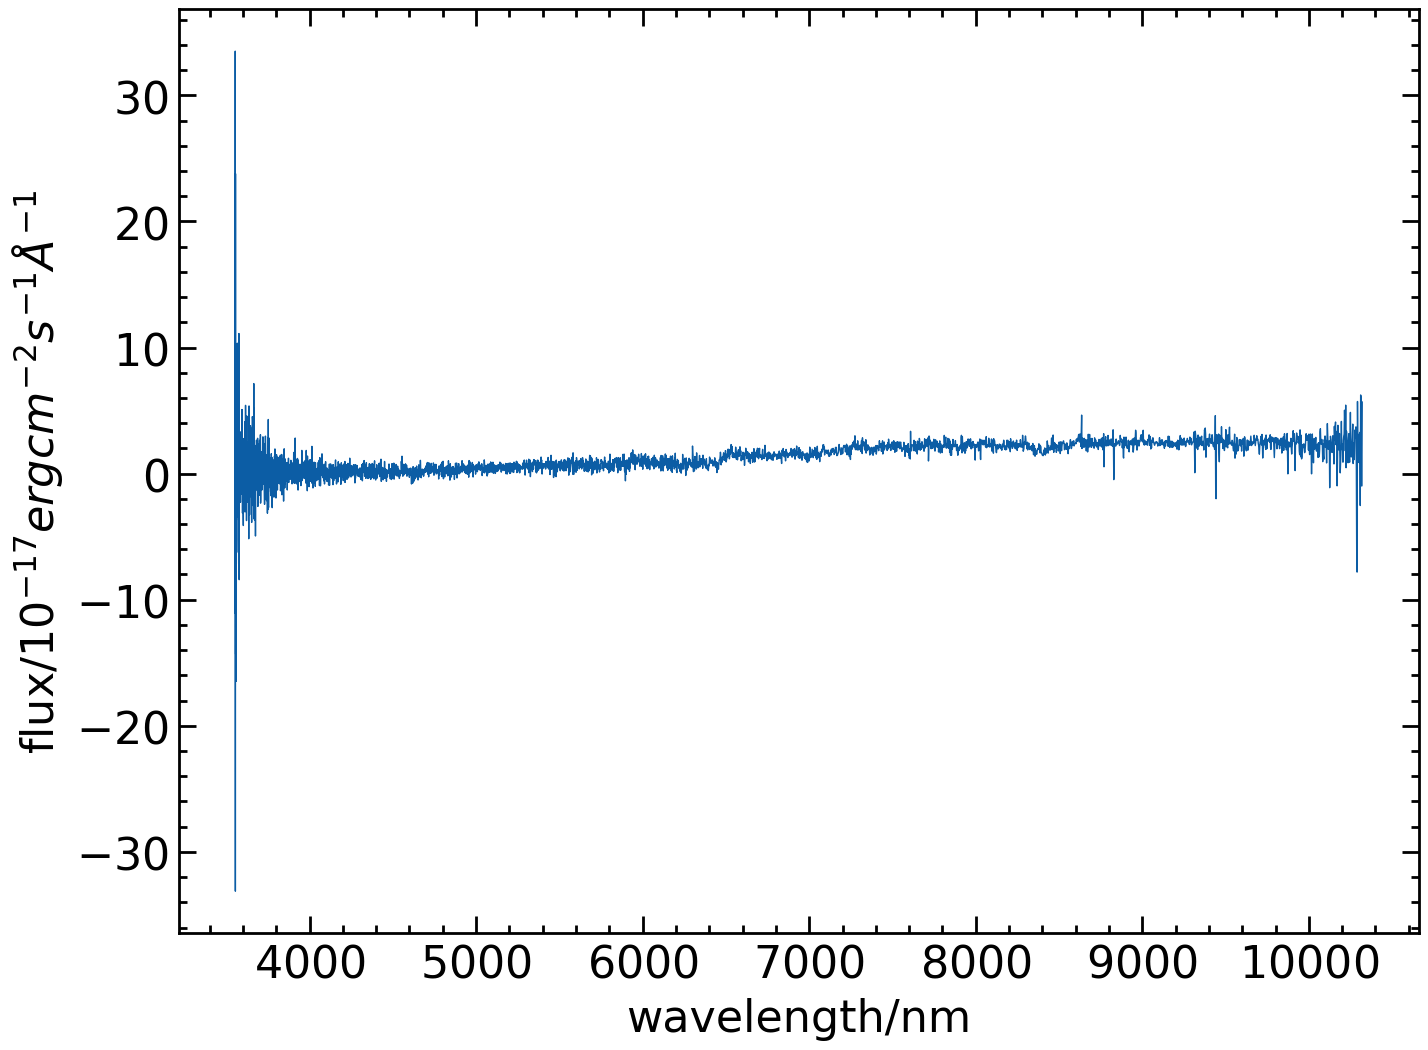

In [4]:
# NOTE: Naming Convention I used: 
# NOTE: xxx_dir for directory only
# NOTE: xxx_name for filename only
# NOTE: xxx_path for a full path like 'directory/filename'
# NOTE: xxx_xxx + s means a list of xxx

data_dir = '/home/yichenliu/machine-learning-demo/data'
data_names = os.listdir(data_dir)
data_paths = [os.path.join(data_dir, name) for name in data_names]

with fits.open(data_paths[0]) as hdu: 
    mask = np.isfinite(hdu[1].data['flux'])
    wavelengths = 10**hdu[1].data['loglam'][mask]
    flux_sdss = hdu[1].data['flux'][mask]
    # print and display data
    hdu.info()
    print(flux_sdss)
    print(type(flux_sdss))
    plt.plot(10**hdu[1].data['loglam'][mask], flux_sdss, 
             label=f'exmple SDSS spectrum', linewidth=0.5)
    plt.xlabel('wavelength/nm')
    plt.ylabel(r'flux/$10^{-17} erg cm ^{-2} s^{-1} \AA^{-1}$')
    plt.show()
    

## Now we use Pytorch to build a simple framework to predict the redshift.

In [61]:
# NOTE: The code blocks below can run without running blocks above.

import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from astropy.io import fits

Define the dataset and dataloader

In [ ]:
# Define the Dataset
class SpectrumDataset(Dataset):
    def __init__(self, data_dir, max_length=5000):
        self.data_paths = [os.path.join(data_dir, name) for name in os.listdir(data_dir)]
        self.data_paths.sort()
        self.max_length = max_length

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        data_path = self.data_paths[idx]
        with fits.open(data_path) as hdu:
            mask = np.isfinite(hdu[1].data['flux'])
            wavelengths = 10**hdu[1].data['loglam'][mask]
            flux = hdu[1].data['flux'][mask]

            # Normalize and pad
            flux = (flux - np.mean(flux)) / np.std(flux)
            wavelengths = (wavelengths - np.mean(wavelengths)) / np.std(wavelengths)
            data = np.stack([wavelengths, flux], axis=1)
            if len(data) > self.max_length:
                data = data[:self.max_length]
            else:
                padding = np.zeros((self.max_length - len(data), 2))
                data = np.vstack([data, padding])

        redshift = float(data_path.split('_z_')[-1].replace('.fits', ''))
        return torch.tensor(data, dtype=torch.float32), torch.tensor(redshift, dtype=torch.float32)

# Prepare DataLoader
data_dir = '/home/yichenliu/machine-learning-demo/data'
dataset = SpectrumDataset(data_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Define the Model

In [62]:
class RedshiftPredictor(nn.Module):
    def __init__(self):
        super(RedshiftPredictor, self).__init__()
        # Sequence model: LSTM
        self.lstm = nn.LSTM(input_size=2, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),  # Reduce LSTM output to smaller dimensions
            nn.ReLU(),
            nn.Linear(64, 1)    # Final output: redshift
        )

    def forward(self, x):
        # x shape: [batch_size, sequence_length, 2]
        lstm_out, _ = self.lstm(x)  # Output shape: [batch_size, sequence_length, 128]
        lstm_out = lstm_out.mean(dim=1)  # Aggregate across sequence dimension
        return self.fc(lstm_out)  # Final prediction: [batch_size, 1]

Initialize Model, Loss Function, and Optimizer, and then train the model

Epoch 1/50, Loss: 0.01384609192609787
Epoch 2/50, Loss: 0.008436751551926136
Epoch 3/50, Loss: 0.010479889810085297
Epoch 4/50, Loss: 0.028170477598905563
Epoch 5/50, Loss: 0.020577238872647285
Epoch 6/50, Loss: 0.004610021132975817
Epoch 7/50, Loss: 0.006461397744715214
Epoch 8/50, Loss: 0.01032880786806345
Epoch 9/50, Loss: 0.016903242096304893
Epoch 10/50, Loss: 0.013429970480501652
Epoch 11/50, Loss: 0.003161545842885971
Epoch 12/50, Loss: 0.004094175063073635
Epoch 13/50, Loss: 0.004419011529535055
Epoch 14/50, Loss: 0.0021708388812839985
Epoch 15/50, Loss: 0.0018541602184996009
Epoch 16/50, Loss: 0.0024151767138391733
Epoch 17/50, Loss: 0.0023882773239165545
Epoch 18/50, Loss: 0.001148751238361001
Epoch 19/50, Loss: 0.002444177633151412
Epoch 20/50, Loss: 0.003154151840135455
Epoch 21/50, Loss: 0.008007345721125603
Epoch 22/50, Loss: 0.003620726754888892
Epoch 23/50, Loss: 0.0018078266875818372
Epoch 24/50, Loss: 0.002298710634931922
Epoch 25/50, Loss: 0.0033674484584480524
Epoch

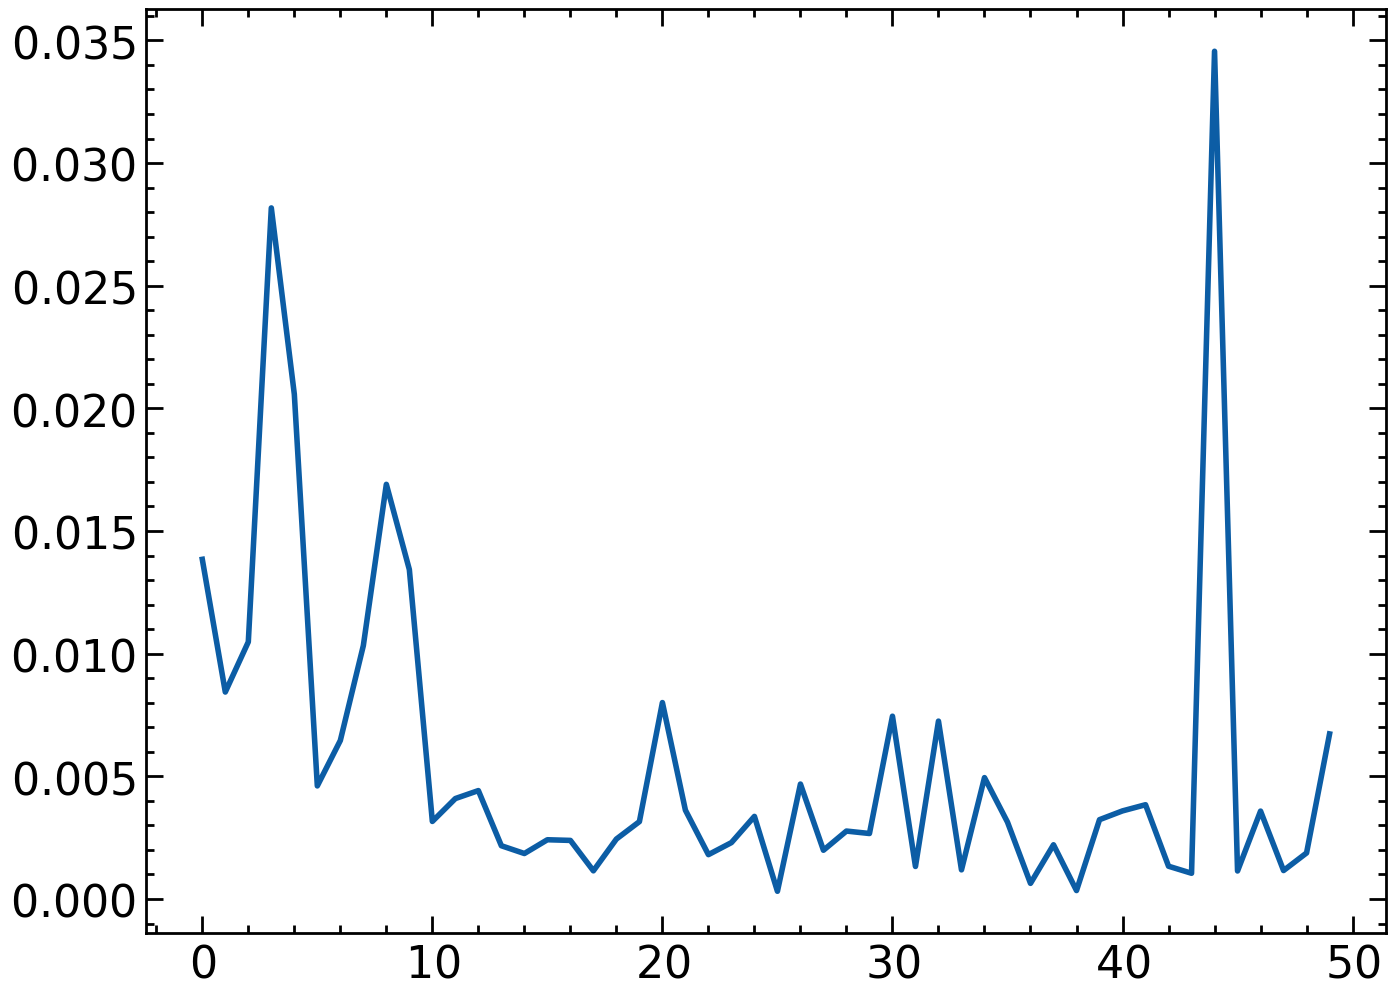

In [ ]:
model = RedshiftPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
losses = []
for epoch in range(epochs):
    model.train()
    for spectra, redshift in train_loader:
        # spectra shape: [batch_size, max_length, 2]
        # redshift shape: [batch_size]
        predictions = model(spectra)  # Output: [batch_size, 1]
        redshift = redshift.view(-1, 1)  # Match output shape
        loss = criterion(predictions, redshift)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

plt.plot(np.arange(len(losses)), losses)
plt.show()

Now we evaluate the model.

Test Loss: 0.006548540247604251


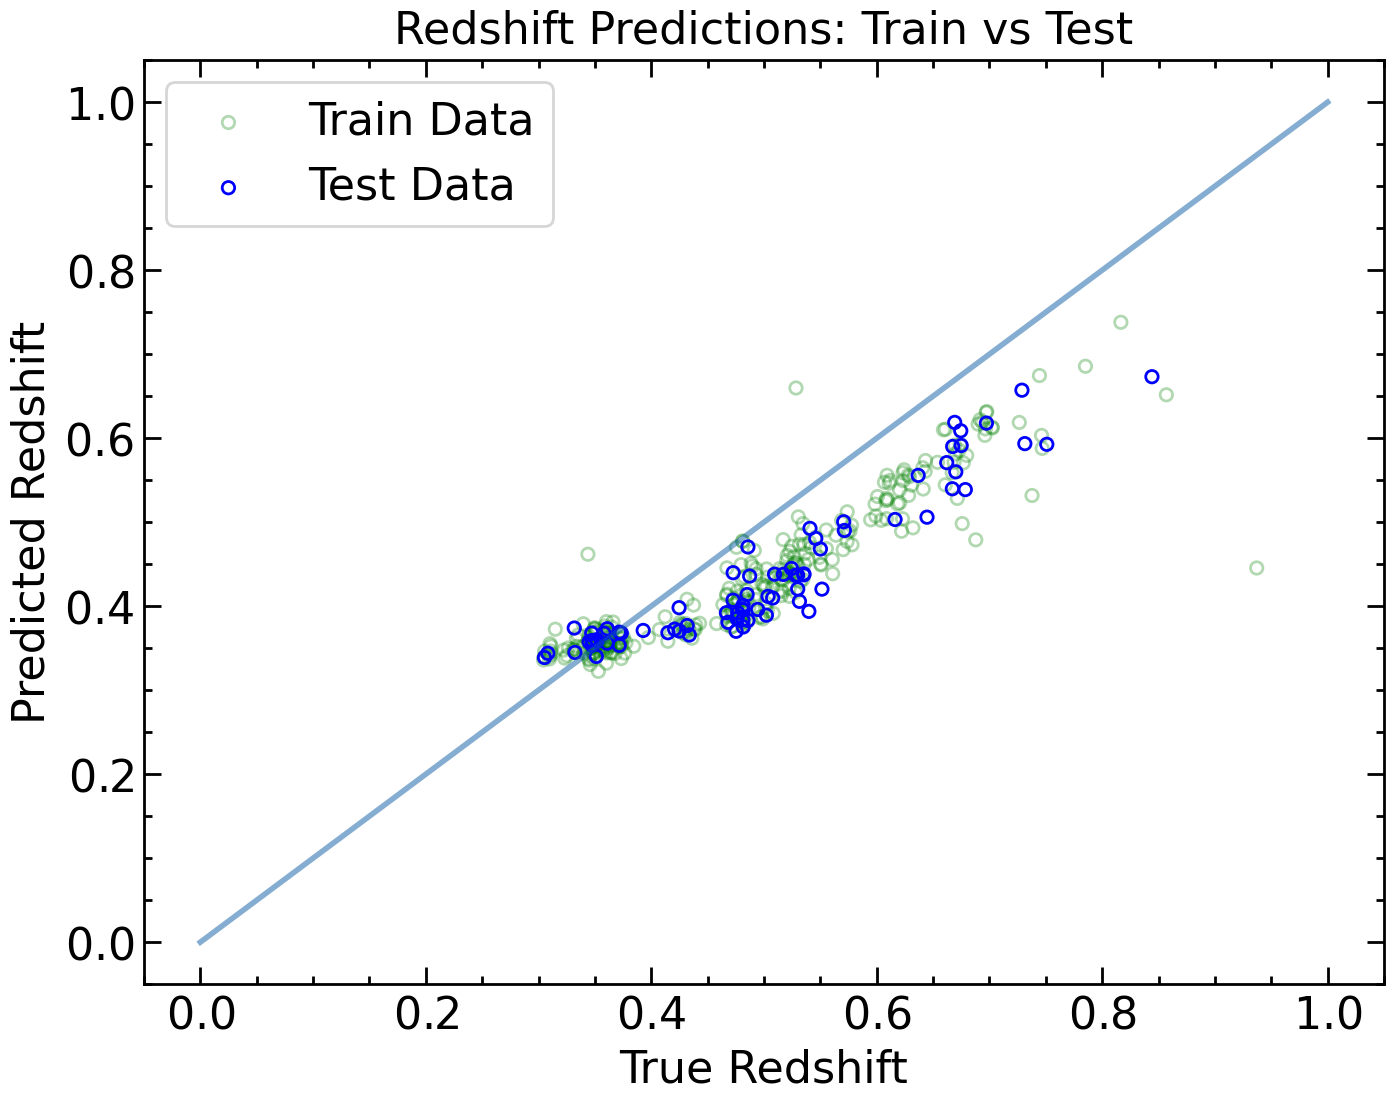

In [16]:
# set the model to evaluate mode
model.eval()

train_redshift, train_predictions = [], []
test_redshift, test_predictions = [], []

# Collect train data
with torch.no_grad():
    for spectra, redshift in train_loader:
        redshift = redshift.view(-1, 1)
        predictions = model(spectra)
        train_redshift.append(redshift)
        train_predictions.append(predictions)

# Collect test data
with torch.no_grad():
    total_loss = 0
    for spectra, redshift in test_loader:
        redshift = redshift.view(-1, 1)
        predictions = model(spectra)
        loss = criterion(predictions, redshift)
        total_loss += loss.item()
        test_redshift.append(redshift)
        test_predictions.append(predictions)
    print(f"Test Loss: {total_loss / len(test_loader)}")

# Combine data and plot
train_redshift = torch.cat(train_redshift).cpu().numpy()
train_predictions = torch.cat(train_predictions).cpu().numpy()
test_redshift = torch.cat(test_redshift).cpu().numpy()
test_predictions = torch.cat(test_predictions).cpu().numpy()

plt.scatter(train_redshift, train_predictions, edgecolors='green', s=20,
            facecolors='none', alpha=0.3, label='Train Data')
plt.scatter(test_redshift, test_predictions, edgecolors='blue', s=20,
            facecolors='none', alpha=1.0, label='Test Data')

# Add legend and labels
plt.legend(frameon=True)
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Predictions: Train vs Test')
plt.plot([0, 1], [0, 1], alpha=0.5)
plt.show()

## Now we use random forest to achieve a similar redshift prediction.

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Flatten the spectral data for Random Forest
def preprocess_data(loader):
    features, targets = [], []
    for spectra, redshift in loader:
        # Flatten each spectrum (sequence_length, 2) -> (sequence_length*2)
        spectra_flat = spectra.view(spectra.shape[0], -1).numpy()
        features.append(spectra_flat)
        targets.append(redshift.numpy())
    return np.vstack(features), np.hstack(targets)

We first show decision tree (can be considered as a part of random forest)

In [65]:
# Preprocess data
train_features, train_targets = preprocess_data(train_loader)
test_features, test_targets = preprocess_data(test_loader)

# Initialize Decision Tree Regressor with custom parameters
dt_model = DecisionTreeRegressor(
    max_depth=15,              # Limit the depth of the tree
    min_samples_split=5,       # Minimum samples to split a node
    min_samples_leaf=3,        # Minimum samples at a leaf node
    max_features=None,         # Consider all features at each split
    random_state=42            # Fix random seed for reproducibility
)

# Train the model
dt_model.fit(train_features, train_targets)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=3, min_samples_split=5,
                      random_state=42)

Train MSE: 0.0002917034288917407
Test MSE: 0.008356717715357103


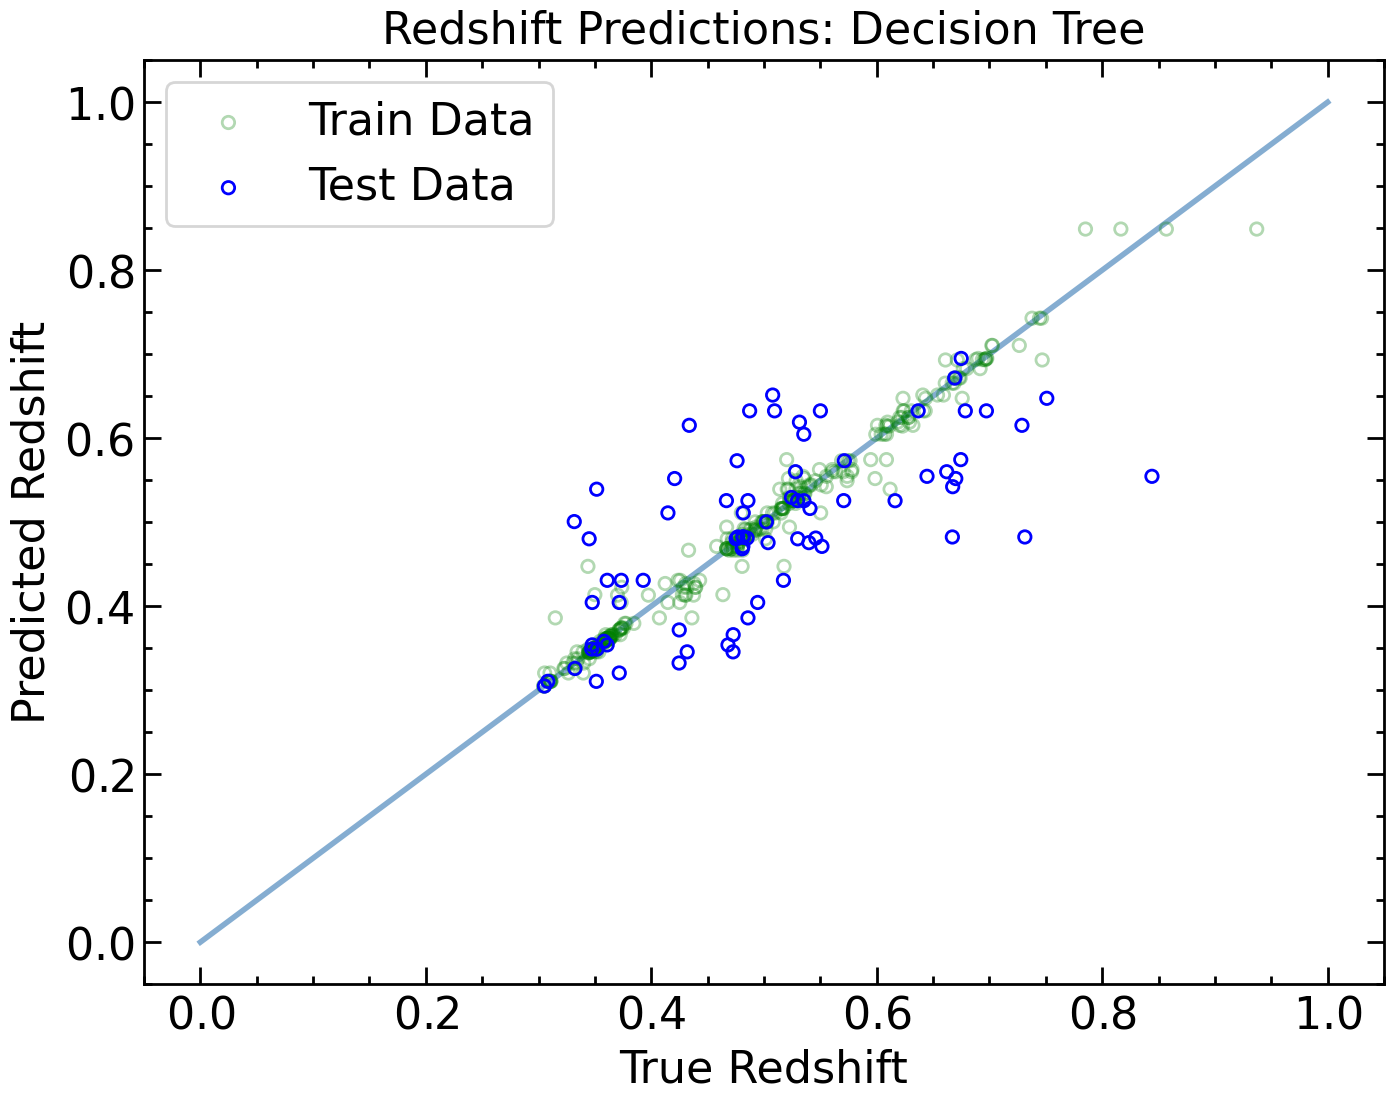

In [66]:
# Make predictions
train_predictions = dt_model.predict(train_features)
test_predictions = dt_model.predict(test_features)

# Compute MSE
train_mse = mean_squared_error(train_targets, train_predictions)
test_mse = mean_squared_error(test_targets, test_predictions)
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


# Visualize predictions
plt.scatter(train_targets, train_predictions, edgecolors='green', 
            facecolors='none', alpha=0.3, label='Train Data', s=20)
plt.scatter(test_targets, test_predictions, edgecolors='blue', 
            facecolors='none', alpha=1.0, label='Test Data', s=20)
plt.legend(frameon=True)
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Predictions: Decision Tree')
plt.plot([0, 1], [0, 1], alpha=0.5, zorder=0)
plt.show()

Now we can move on to random forest. 

In [67]:
# Prepare the train and test data
train_features, train_targets = preprocess_data(train_loader)
test_features, test_targets = preprocess_data(test_loader)

# Initialize Random Forest Regressor with custom parameters
rf_model = RandomForestRegressor(
    n_estimators=100,       # Use 200 trees instead of the default 100
    max_depth=15,           # Limit the depth of each tree to 15
    # min_samples_split=5,    # Require at least 5 samples to split
    # min_samples_leaf=2,     # Require at least 2 samples in leaf nodes
    # max_features='sqrt',    # Use the square root of features for each split
    random_state=42         # Set random seed for reproducibility
)

rf_model.fit(train_features, train_targets)

RandomForestRegressor(max_depth=15, random_state=42)

Train MSE: 0.0006862299936744754
Test MSE: 0.004624084742304859


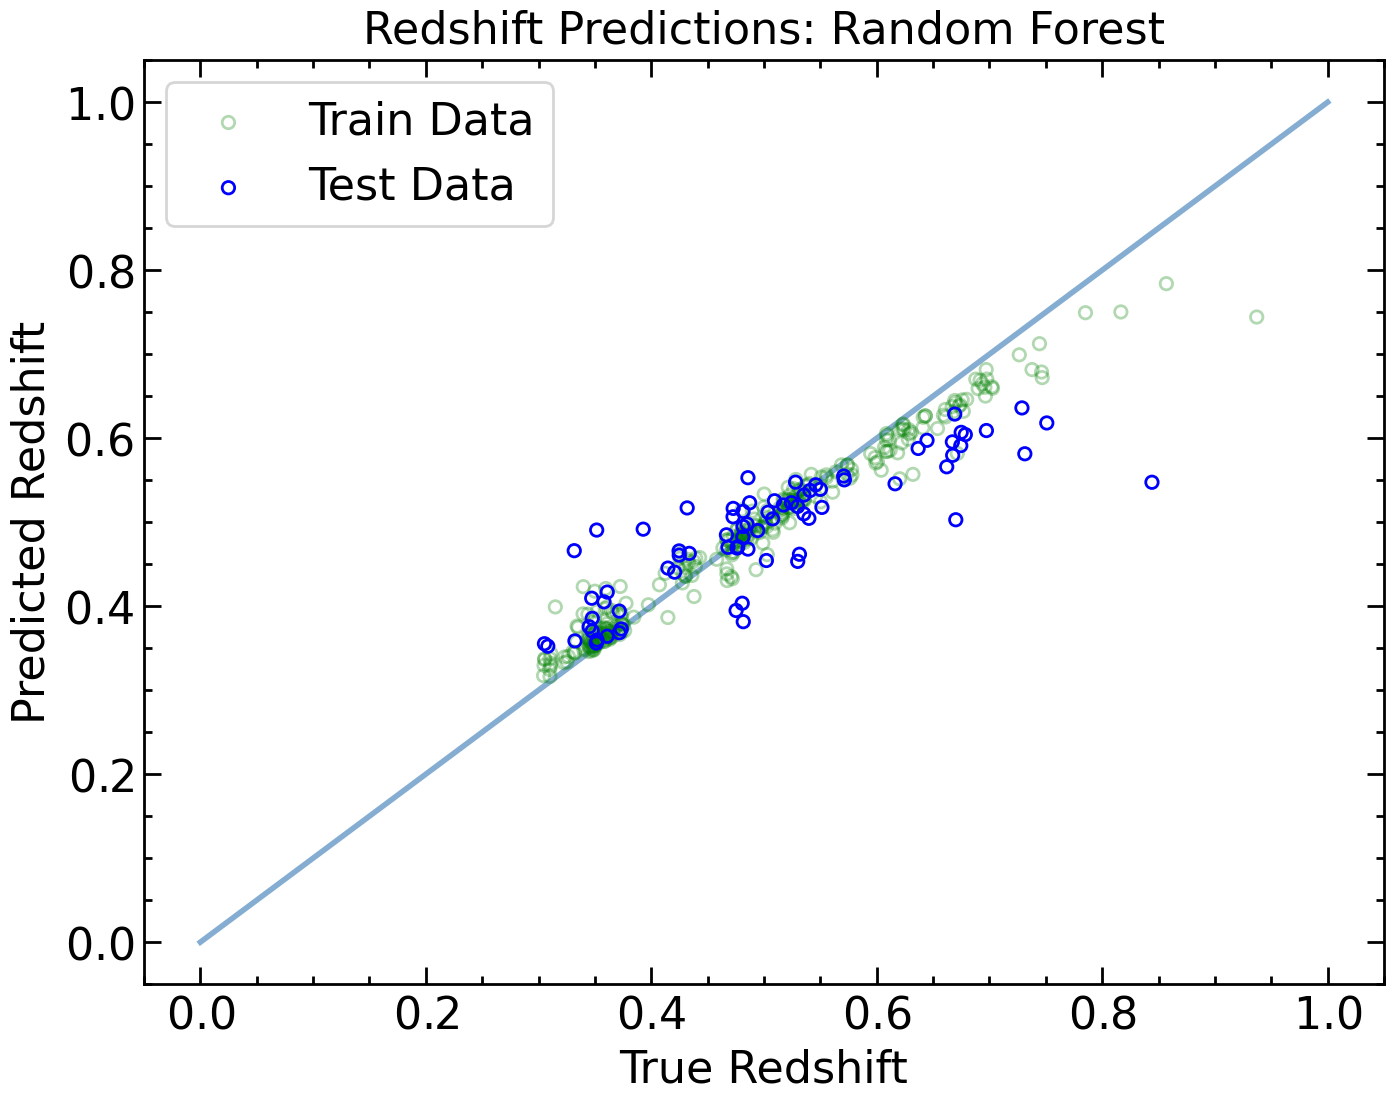

In [68]:
# Make predictions
train_predictions = rf_model.predict(train_features)
test_predictions = rf_model.predict(test_features)

# Compute MSE
train_mse = mean_squared_error(train_targets, train_predictions)
test_mse = mean_squared_error(test_targets, test_predictions)
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


# Visualize predictions
plt.scatter(train_targets, train_predictions, edgecolors='green', 
            facecolors='none', alpha=0.3, label='Train Data', s=20)
plt.scatter(test_targets, test_predictions, edgecolors='blue', 
            facecolors='none', alpha=1.0, label='Test Data', s=20)
plt.legend(frameon=True)
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Predictions: Random Forest')
plt.plot([0, 1], [0, 1], alpha=0.5, zorder=0)
plt.show()

For people more interested in random forest, here is a sturcute of it.

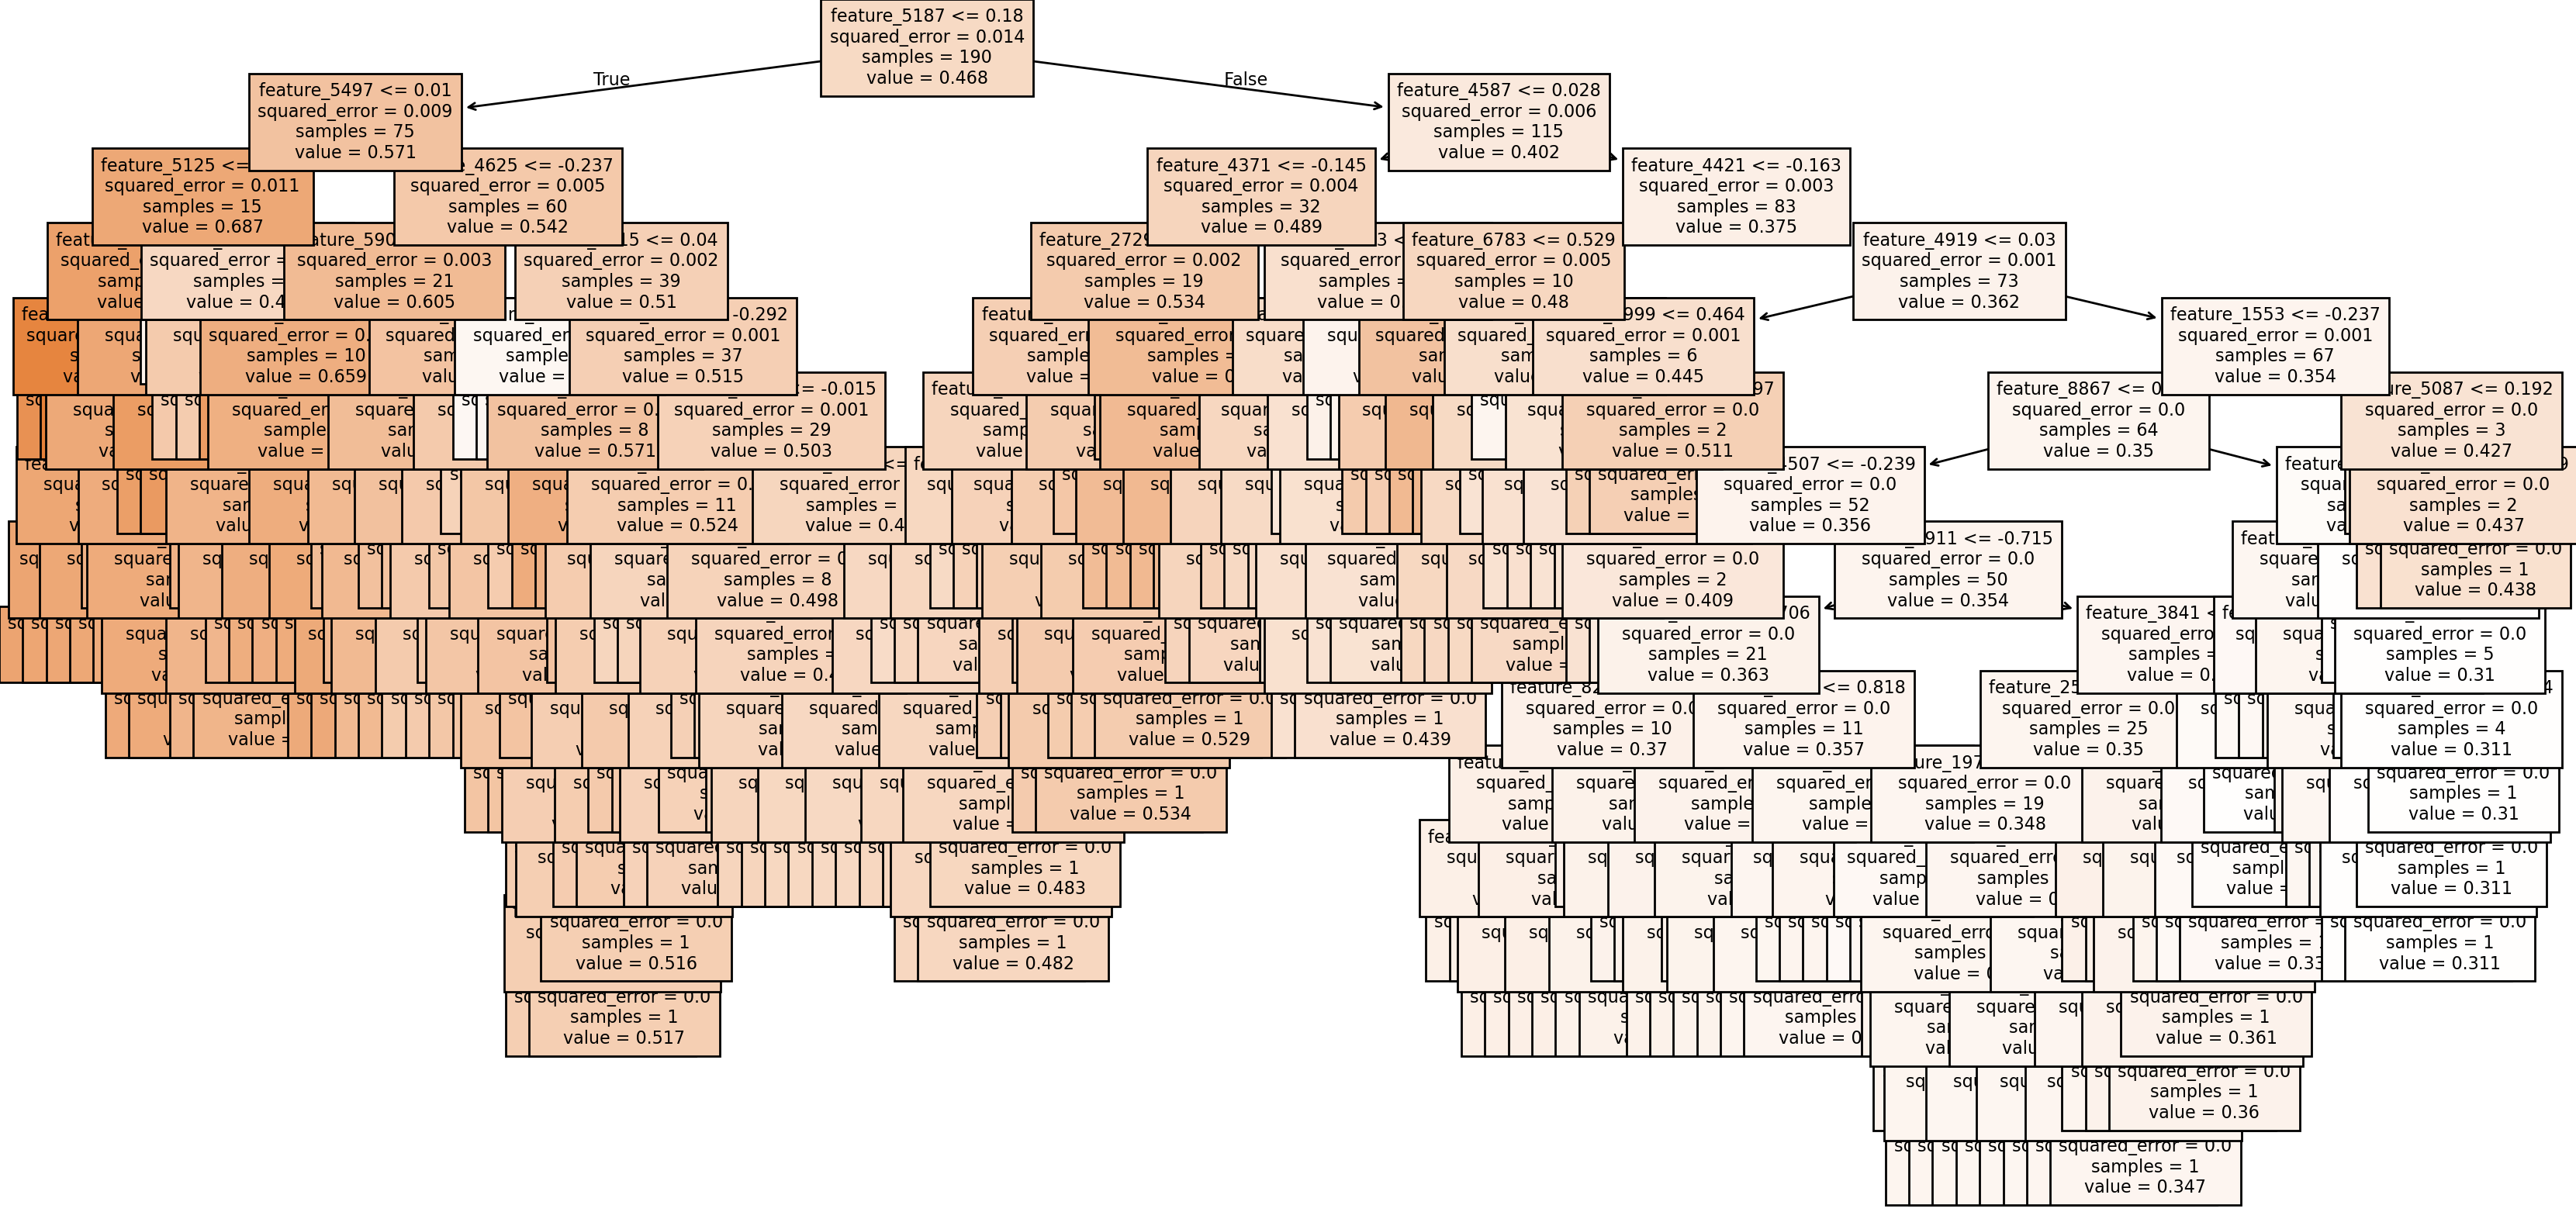

In [69]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Access the first tree in the forest
tree = rf_model.estimators_[0]

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=[f'feature_{i}' for i in range(train_features.shape[1])], filled=True, fontsize=8)
plt.show()


# TESTING CODE

In [11]:
sdss_dir = '/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/dwarf_agn_cosmos/spec/sdss'

load data and spectra

In [29]:
data_used = data_agn_download[data_agn_download['spec_sdss']==True]
data_used = data_used['ID', 'z_sdss']

data_used

ID,z_sdss
int64,float64
2,3.503096
7,1.964449
8,2.002805
12,1.517696
24,1.29498
26,0.8165838
28,2.836788
34,0.6573269
36,2.120248


In [38]:
data_used['spec_sdss'] = None

for i, ID in enumerate(data_used['ID']):
    
    if os.path.isfile('/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/dwarf_agn_cosmos/spec/SDSS/sdss_%d.fits'%ID): 
        
        # z_sdss = data_agn_download['z_sdss'][ID-1]

        hdu = fits.open('/mnt/c/Users/Chisen/OneDrive - University of Illinois - Urbana/Research/dwarf_agn_cosmos/spec/SDSS/sdss_%d.fits'%ID)
        mask = np.isfinite(hdu[1].data['flux'])
        flux_sdss = convolve(hdu[1].data['flux'][mask], Box1DKernel(width=10))
        # plt.plot(10**hdu[1].data['loglam'][mask], flux_sdss,
        #          label=f'SDSS (z={z_sdss})', color='bisque', linewidth=1);
        
        # mask = np.isfinite(flux_sdss)
        # # ylim = np.max([ylim, np.nanmax(flux_sdss[mask])])
        # plt.show()
        data_used['spec_sdss'][i] = flux_sdss

In [41]:
data_used

ID,z_sdss,spec_sdss
int64,float64,object
2,3.503096,[ 3.0981514 3.2805538 3.2138364 ... -0.4458007 -0.4835227\n -0.23445086]
7,1.964449,[3.159988 3.5302465 4.2038445 ... 1.3414261 1.2299198 1.0782471]
8,2.002805,[ 7.3482103 8.851166 10.515259 ... 1.928333 1.7331293 1.6054761]
12,1.517696,[2.9695315 3.5894563 3.9259272 ... 0.94993556 0.7889638 0.6004343 ]
24,1.29498,[3.5984263 3.9862902 4.4195385 ... 0.636673 0.4775936 0.36652195]
26,0.8165838,[ 2.1330068 2.380124 1.6383008 ... -0.8630246 -0.70636976\n -0.01306987]
28,2.836788,[1.9543664 2.3663187 2.2342982 ... 0.3530498 0.39357358 0.89810663]
34,0.6573269,[12.9117565 15.081478 17.273003 ... 3.0781853 2.7510052 2.3495097]
36,2.120248,[1.0297496 1.2198974 1.6704905 ... 1.347306 1.9933274 1.7795227]


### Now we load the data into NN.

parse data

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from astropy.table import Table
import torch
from torch.utils.data import Dataset, DataLoader

# Load the data (assuming it's already loaded into an astropy table named `data_used`)
# data_used = Table.read('path_to_file')  # Uncomment if loading from a file

# Extract spectral data and specz from the table
spectra = [list(row['spec_sdss']) for row in data_used]
specz = list(data_used['z_sdss'])

# Convert spectra to a NumPy array for processing
import numpy as np
spectra = np.array(spectra)
specz = np.array(specz)

# Normalize the spectra
spectra = (spectra - spectra.mean(axis=1, keepdims=True)) / spectra.std(axis=1, keepdims=True)
# Normalize the specz values
specz = (specz - specz.min()) / (specz.max() - specz.min())


Custom Dataset Class

In [ ]:
class SpectraDataset(Dataset):
    def __init__(self, spectra, specz):
        self.spectra = torch.tensor(spectra, dtype=torch.float32)
        self.specz = torch.tensor(specz, dtype=torch.float32)

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.specz[idx]

# Create training and testing datasets
split_idx = int(0.8 * len(spectra))
train_spectra, test_spectra = spectra[:split_idx], spectra[split_idx:]
train_specz, test_specz = specz[:split_idx], specz[split_idx:]

train_dataset = SpectraDataset(train_spectra, train_specz)
test_dataset = SpectraDataset(test_spectra, test_specz)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


NN definition

In [ ]:
class SpeczPredictor(nn.Module):
    def __init__(self, input_dim):
        super(SpeczPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Single output for regression
        )

    def forward(self, x):
        return self.network(x).squeeze()


training and testing

In [ ]:
# Instantiate model, loss, and optimizer
model = SpeczPredictor(input_dim=train_spectra.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for spectra_batch, specz_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(spectra_batch)
        loss = criterion(predictions, specz_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')

# Testing loop
model.eval()
test_loss = 0
with torch.no_grad():
    for spectra_batch, specz_batch in test_loader:
        predictions = model(spectra_batch)
        loss = criterion(predictions, specz_batch)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
